# Project 1: Catastrophe Model for Flooding in Phoenicia, NY

## Executive summary: 

I'm very interested in catastrophe modeling. To learn more about the field and learn some new Python tools (in geospatial analysis), I decided to create a toy catastrophe model for flooding in Phoenicia, NY. My priority in creating this model was to understand how catastrophe models work, and not to produce realistic estimates of risk for Phoenicia, NY. Therefore, the model makes a lot of assumptions about the flooding process, building properties, and the way in which flooding translates into monetary damages. These assumptions made the model much easier to construct and run but come at a huge expense in terms of realism. You will find a write-up for the project in the document below. In **Section 1**, I provide some brief background regarding my motivation, the town of Phoenicia, and catastrophe modeling in general. In **Section 2**, I outline how my model calcaulates damage for a single generated event. In **Section 3**, I give a general risk assessment for the town of Phoeniica using 3000 simulation-years with my toy model. Finally, in **Section 4** I summarize the assumptions that went into my model and speak about how I might improve the model, given more time and computational resources. 

## Table of contents: 
[1. Introduction](#section1)

[2. Simulation of a single catastrophic event](#section2) 

* [a. Event generation](#section2a)
* [b. Local intensity calculation](#section2b)
* [c. Exposure data](#section2c)
* [d. Damage calculation](#section2d)

[3. Assessment of risk](#section3)

[4. How the model might be improved](#section4) 


## 1. Introduction: <a name="section1"></a>

I spent a lot of time in Phoenicia as a kid--a family friend lived there and my family visited often. In August 2011, Tropical Storm Irene made landfall in Brooklyn and brought torrential rain to the Catskills. Phoenicia experienced extreme flooding: many roads were washed out, and many residential/commerical properties were damaged. This came to mind while I was considering ideas for a toy catastrophe model, so I decided to make a toy catastrophe flood model for Phoenicia, NY. 

Phoenicia is a small hamlet of about 300 people, located in the Catskill mountains of NY, in Ulster County. It lies in a mountain valley near the intersection between the Esopus creek and the smaller Stony Clove creek. If you scroll down to the first figure in this document, you can see a map of Phoenicia. The Stony Clove and Esopus Creeks are labeled. The gray lines denote streets, while the black dots denote residential/commerical addresses. You can [read more about Phoenicia here](https://en.wikipedia.org/wiki/Phoenicia,_New_York), if you'd like.

Catastrophe models are used to estimate financial risk arising from natural and man-made catastrophes, such as floods, earthquakes, hurricanes, terrorism, cyber attacks, wildfires, and droughts. The risk information is used to set insurance premiums, inform reinsurance sales, inform risk mitigation decisionmaking, and for other purposes. Catastrophe models typically include: 

1. **An event generator**, which is used to generate thousands of events according to an assigned distribution of physical possibilities. For a flood model, the model might randomly (stochastically) generate a stream gauge height according to a historical distribution of stream gauge heights and their associated probabilities.  
2. **A local intensity calculator**, which calculates the intensity of the catastrophic event at the site of each  property of interest. In a flood model, this might include the inundation depth, the water flow velocity, and the duration of inundantion. 
3. **Exposure data**, or information related to each property of interest. For a flood model, this would ideally include everything there is to know about the property--building material, square footage, contents, whether there is a basement, cost of replacement, etc. 
4. **A damage calculator**, which includes a set of damage functions. The damage functions use the exposure data and local intensity calculations to calculate the ratio of the damage to the cost of replacement for each property. 
5. **A financial portion**. Typically included if the insurance industry is using a catastrophe model. The financial portion uses the insurance policy conditions and details regarding the damage to predict claims from each property. 

Output from a catastrophe model typically an exceedance probability curve, which gives the probability that any given level of loss will be exceeded in a given time period (such as one year, ten years), return periods for several benchmark levels of loss, and some other key metrics. Sources for information on cat modeling: [source1](https://www.air-worldwide.com/publications/brochures/documents/about-catastrophe-models/), [source2](https://www.rms.com/blog/2015/06/22/what-is-catastrophe-modeling/). 

In the following sections, I present my implementation of a catastrophe model for flooding in Phoenicia, NY in Python. The code includes the following dependencies: numpy, pandas, geopandas, rasterio, shapely, XX. Make sure you have these installed if you want to run the code on your own. You won't need to run the code to view the results. 

In [1]:
# Import modules, set key paths. 
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Polygon,Point,LineString,MultiPolygon
from scipy import interpolate
import time
import datetime
import seaborn as sns
plt.style.use('classic')
#plt.style.use('seaborn-dark')
%matplotlib inline

data_path = './selected_data'

## 2. Simulation of a single catastrophic event: <a name="section2"></a>

### a. Event generation <a name="section2a"></a>
In order to generate events, I use ten years of stream gage data from USGS gages on the Esopus and Stony Clove creeks, which are both located several miles upstream of Phoenicia. 

Outline of the event generator: 
* I divide the ten years of observations into weeks, retrieve the gage heights on the Esopus and Stony Clove creeks ($gh_e$, $gh_s$) at the time when $[gh_e^2 + gh_s^2]$ is largest during each week. I store those gage heights in a .csv file, along with the month corresponding to the center of that week.  
* To generate an event for a given week, I randomly select a week that corresponds to the given month and retrieve the $gh_e$ and $gh_s$ for that week. 
* I use these $gh_e$ and $gh_s$ in the damage calculations. 
* All gage heights are normalized by subtracting the 11-year mode (computed after binning gage heights in 0.5 meter intervals, represents "normal") from the observations. The observations are also converted from feet to meters. 

Assumptions that the event generator makes: 
* Maximum gage heights during each week are independent of each other. Not necessarily true--stream discharge does not always "re-set" itself from one week to the next. 
* That the most commonly observed gage height is "normal", and corresponds to the elevation of the stream in the DEM data. Not necessarily true--DEM might have been created at a time when stream heights were not normal. 
* Water level departures from normal at the gage heights are the same as those in Phoenicia at any given time. This isn't necessarily true--flow velocities and streambed shapes in Phoenicia and at the gages aren't necessarily identical. 
* I  assume that those ten years of observations are representative of the climate state in which they occurred, and are representative of the climate state in the time period I'm attempting to simulate. Not necessarily true--ten years is a short period, and Phoenicia's climate is changing. 

The code below demonstrates how an event can be randomly generated for the month of April. Note that this randomly generated event is overridden with another, corresponding to Tropical Storm Irene, in the last few lines of the cell below. It's better to demonstrate how the catastrophe model works with an example of a flood. 

In [2]:
# Import file used for event generation: 
weekly_max_gh = pd.read_csv(os.path.join(data_path,'weekly_max_gage_heights.csv'),usecols=[1,2,3])

# Function for event generation
from toy_model_module import generate_week

# Function for calculating sign of number (+/-)
sign = lambda x: (1, -1)[x < 0]

# Function for determining water level downstream of the merge between the Esopus and 
# Stony Clove creeks. 
def merged_water_level(ghe,ghs,sign):
    if sign(ghe*ghs) == 1:
        ghm = sign(ghe)*np.sqrt(ghe**2+ghs**2)
    elif sign(ghe*ghs) == -1:
        sum_sqr = sign(ghe)*(ghe**2)+sign(ghs)*(ghs**2)
        ghm = sign(sum_sqr)*np.sqrt(np.abs(sum_sqr))
    return ghm

# Generate event, compute gage height after the merge between the to streams.
ghe,ghs = generate_week(weekly_max_gh,month_of_week=4)
flood = {'esopus': ghe, 'stony_clove': ghs}
flood['merged'] = merged_water_level(ghe,ghs,sign)

# NOTE: I override this random generation for demonstrative purposes. 
# Demonstration corresponds to the flooding during Tropical Storm Irene. 
flood = {'esopus': 4, 'stony_clove': 2}
flood['merged'] = merged_water_level(flood['esopus'],flood['stony_clove'],sign)

### b. Local intensity calculation <a name="section2b"></a>
My goal is to calculate the inundation at the location of each property in Phoenicia, for the event generated above. This will require geospatial data from several sources:
* [10m Digital Elevation Model](https://orthos.dhses.ny.gov/#)
* [Stream locations](https://ulstercountyny.gov/sites/default/files/gis-data/Ulster-County-Hydrography.zip) (clicking this link will download the file directly)
* [Address points for Ulster County](http://gis.ny.gov/gisdata/inventories/details.cfm?DSID=921)
* [Streets in NY state](http://gis.ny.gov/gisdata/inventories/details.cfm?DSID=932)

Note that several files linked above contain data for the entirety of NY State, or for the entirety of Ulster County. Most of this data is unnecessary for my purposes--I only need data for the small region around Phoenica. I extracted data corresponding to this small region using code in 'extract_necessary_data.ipynb' and stored the data in the directory './selected_data'. All this data is imported in the cell below.


In [3]:
# Functions for saving/loading data from .pkl files. 
from toy_model_module import save_load_pkl

# DEM for area around Phoenicia. 
local_dem = save_load_pkl.load_obj(os.path.join(data_path,'local_DEM.pkl'))
zoom_x,zoom_y,zoom_elev,zoom_bounds,default_crs = local_dem['dem_X'],local_dem['dem_Y'],local_dem['dem_Z'],local_dem['zoom_bounds'],local_dem['crs']
zoom_polygon = Polygon([(zoom_bounds['min_x'],zoom_bounds['min_y']), 
                       (zoom_bounds['min_x'],zoom_bounds['max_y']),
                       (zoom_bounds['max_x'],zoom_bounds['max_y']),
                       (zoom_bounds['max_x'],zoom_bounds['min_y'])])

# Shapefile with LineStrings for Esopus and Stony Clove Creeks. 
creeks = gpd.read_file(os.path.join(data_path,'creeks.shp'))

# Shapefile with LineStrings for roads/streets around Phoenicia. 
streets = gpd.read_file(os.path.join(data_path,'streets.shp'))

# Shapefile with address points around Phoenicia (location of all public/private/commerical properties)
adpts = gpd.read_file(os.path.join(data_path,'address_points.shp'))

# CSV file that includes x coordinate, y coordinate, elevation, creek name, and creek point ID for 
# each point used to create the creek LineStrings. 
creek_points = pd.read_csv(os.path.join(data_path,'creek_points.csv'))
creek_points = creek_points.drop('Unnamed: 0', axis=1)

# CSV file I use to map each point on the DEM to the nearest point on a creek. Contains the x 
# coordinate, y coordinate, elevation, for each point in the DEM. For each of those points, the CSV 
# file also includes the elevation, creek name, and ID for the nearest point that's on a creek. 
dem2creek = pd.read_csv(os.path.join(data_path,'dem2creek.csv'))
dem2creek = dem2creek.drop('Unnamed: 0', axis=1)


In the next cell, I'll plot some of this data to show what the region surrounding Phoenicia looks like. The plot shows contours of elevation (in meters, colorbar on the right), the Esopus and Stony Clove Creeks (blue, labeled), roads/streets (gray), and addresspoints in Phoenicia (black). The plot also includes a hillshade layer to help visualize the terrain features. The addresspoints correspond to the properties that are of concern in the catastrophe model. Note that there are other addresspoints in the region, which have not been plotted because they are not in the hamlet of Phoenicia. You'll notice that many of the addresspoints lie in the floodplain. Oops! 

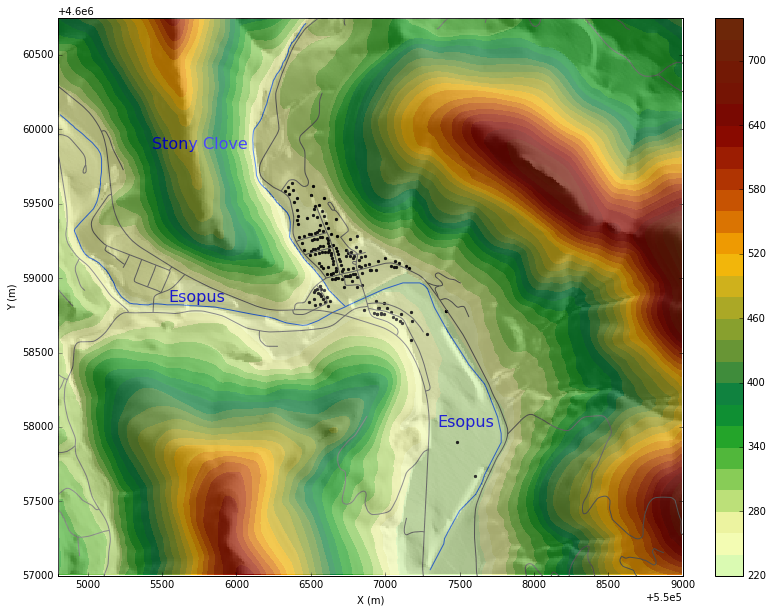

In [4]:
# Import function that plots the basis for every flooding event around Phoenicia
from toy_model_module import plot_phoenicia_base

# Set colormap
try:
    import pycpt
    topocmap = pycpt.load.cmap_from_cptcity_url('wkp/schwarzwald/wiki-schwarzwald-cont.cpt')
    vminmax = [150, 1000]
except:
    topocmap = 'terrain'
    vminmax = [-100, 800]

# Plot. 
fig = plt.figure(figsize=(14.5, 10))
ax = fig.add_subplot(111)
CS = plot_phoenicia_base(ax,zoom_x,zoom_y,zoom_elev,topocmap,vminmax,creeks,streets,zoom_bounds,only_phoenicia=False)
adpts[(adpts['Unincorpor']=='Phoenicia')].plot(ax=ax,color='k',markersize=5)
plt.colorbar(CS,fraction=0.038, pad=0.04)
plt.text(555540,4658845,'Esopus',color='blue',fontsize=16)
plt.text(555430,4659870,'Stony Clove',color='blue',fontsize=16)
plt.text(557350,4658000,'Esopus',color='blue',fontsize=16)
plt.show()

In the following cell, I calculate the inundation depths at each point on the DEM and then at each property in Phoenicia, for the flood event specified above. 

My methodology is pretty rudimentary: 
1. For the given flood event, I calculate the water level at each "creek point", or point that defines the creeks in the shapefiles. 
   * For points upstream of the stream confluence: $z_{water} = max([z_{creekpt} + \Delta z_{flood}], [z_{creekpt,confl} + \Delta z_{flood,confl}])$, where $z_{water}$ is the water level at the creek point with flooding, $z_{creekpt}$ is the elevation at the creek point without flooding, $\Delta z_{flood}$ is flood height, and the subscript "confl" deontes the point at which the two streams converge. The above method ensures that there isn't a large discontinuity in water level at the intersection point. 
   * For points downstream of the confluence, I transition from the water level at the point of confluence to the water level calculated by adding the $\Delta z_{flood}$ to $z_{creekpt}$ for a given creek point, over a fading distance ($d_{fade}$) of 750 m. This strategy ensures that discontinuities do not occur in the inundations near the point of confluence. The equations below demonstrate how this is implemented (note: $x_{creekpt}$ and $y_{creekpt}$ are the x and y coordiantes of a given creek point): 
   
   
   $$fact =  \frac{1}{d_{fade}} min \Big(sqrt \big[x_{creekpt}-x_{creek_pt,confl})^2+(y_{creekpt}-y_{creek_pt,confl})^2 \big],d_{fade} \Big)$$
   
   $$z_{flood} = fact*(z_{creekpt}+ \Delta z_{flood}) + [1-fact]*(z_{creekpt,confl} + \Delta z_{flood,confl})$$
   <br> 
2. Then I assign the water level at the nearest "creek point" to each point on the DEM grid. This water level is greater than the DEM point's elevation, then the point experiences flooding. The inundation at that point is the difference between the assigned water level and the DEM point's elevation. 
3. Since I use a list of DEM points to perform the calculations in step 2 (dem2creek dataframe), I reshape the flood statuses and inundations in the list to a 2D array, so that I can more easily determine inundations at specific points. 
4. Then I calculate the inundation at each addresspoint (property) in Phoenicia by interpolating the 2D array of inundation depths. 

This methodology makes several assumptions that probably aren't valid:
* That all flooding in Phoenicia originates from from the Esopus and Stony Clove creeks. This isn't necessarily true--there are a bunch of smaller streams that run nearby, and that flow into the Esopus between the stream gage and Phoenicia. 
* That the water levels during a flood can be calculated as I did above. Probably not--water levels at a given point depend on flow velocity, stream bed shape, and other factors that I do not take into account. 
* That my data provides accurate estimates of the terrain, where the creeks flow, where the addresspoints are. I have reason to believe they don't--at some points, the stream shapes do not follow the valley (run a few meters up the sides). In addition, some addresspoints experience flooding when $\Delta z_{flood}$ is set to zero everywhere. This doesn't make much sense because the structures wouldn't be there if they were perpetually flooded. For the purposes of these toy models, I just removed all properties that flood when $\Delta z_{flood} < 1 m$. Furthermore, several several-meter jumps in elevation occur in the streambeds in the DEM, in places where there clearly aren't waterfalls. 

We'll take a look at the methodology's representation of flooding in the following cell. 

In [5]:
# Calculate the flooding creek height at each point used to define the creeks in the shapefiles. 
# Put in FCN below. 
#del(flooding_fcns)
#del(flood_fcns)
from toy_model_module import flooding_fcns

# Initialize class for calculating flood extent, inundation at each grid point. 
flood_fcns = flooding_fcns(zoom_x,zoom_y)

# Calculate water level at each point on the creeks. 
creek_points2 = flood_fcns.determine_z_flood(creeks,creek_points,flood)

# Assign a water level to each DEM point--water level at stream point that's nearest 
# the DEM point. 
df_map = creek_points2[['crkpt_id','Z_flood']]
dem2creek2 = pd.merge(dem2creek, df_map, left_on='crkpt_id', right_on='crkpt_id')

# Using the water levels, determine whether each point on DEM grid floods. If so, 
 # also determine the inundation at that point. 
dem2creek2['gd_inund'] = dem2creek2['Z_flood']-dem2creek2['Z']
dem2creek2['gd_inund'] = dem2creek2['gd_inund'].apply(lambda x: max(x,0))
dem2creek2['flooded'] = dem2creek2['gd_inund']>0

# Create 2D arrays of flooding status, inundation, which are on DEM grid. 
zoom_flooded, zoom_inundat = flood_fcns.flood_to_dem_grid(dem2creek2[['X','Y','flooded','gd_inund']])

# Create multipolygon to denote the regions that have flooded. Place the multipolygon
# in a geodataframe. We will use this for mapping purposes
flood_pgon_gdf = flood_fcns.create_flood_multipolygon(zoom_flooded)

# Interpolate with 2D array of inundation to calculate the inundation at each address point. 
adpts = flood_fcns.inundation_at_adpts(zoom_inundat,adpts)



So now we've determined the flood extent and the inundation at each poperty in Phoenicia for this flood event. These are displayed in the plot below. The flood extent is plotted in blue, the properties unaffected by flooding are plotted in black, and the properties affected by flooding are plotted in colors that correspond to their inundation. The colorbar is for inunation (in meters). 

Overall, the toy model's diagnosis of flooding isn't too bad! An engineering firm conducted a Local Flood Analysis for Phoenicia several years ago, and an [article](https://hudsonvalleyone.com/2016/01/30/shandaken-hears-of-floodplain-modification/) covering their analysis includes a plot of their estimates of flood extent and flow velocity during TS Irene. If you compare the plot below with the engineering firm's plot, you'll see my estimates of flood extent aren't too far off! 

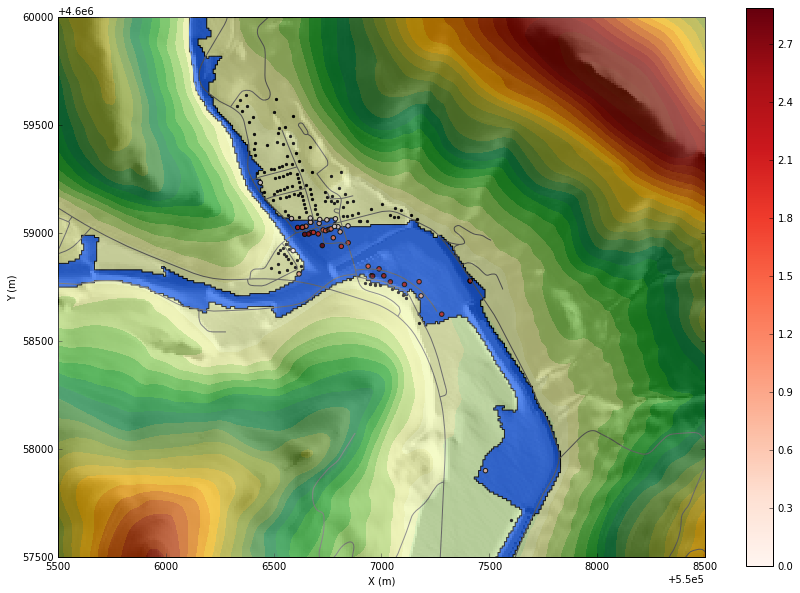

In [6]:
# Isolate affected properties
aff_prop = adpts[(adpts['gd_inund']>0) & (adpts['Unincorpor']=='Phoenicia')]

# Plot to see where flooding occurred. 
fig = plt.figure(figsize=(14.5, 10))
ax = fig.add_subplot(111)
plot_phoenicia_base(ax,zoom_x,zoom_y,zoom_elev,topocmap,vminmax,creeks,streets,zoom_bounds,only_phoenicia=True)
flood_pgon_gdf.plot(ax=ax,color='#1D64F3')
adpts[(adpts['Unincorpor']=='Phoenicia')].plot(ax=ax,color='k',markersize=5)
aff_prop.plot(ax=ax,column='gd_inund',markersize=20,cmap='Reds',legend=True)
plt.show()


### c. Exposure data <a name="section2c"></a>

For this toy model, I'm happy not knowing very much about each property--maybe just its type (commercial/residential) and its cost of replacement. 
* From Google Maps, it seems like almost all of the commercial properties are on Main street and have street numbers lower than 90. Therefore, I'll assume that all properties satisfying these conditions are commercial, and that all other properties are residential. 
* I'll also assume that costs of replacement for residential properties follow a normal distribution with mean 290k and standard deviation 70k, with no properties having costs of replacement below 50k. This roughly follows information from [homeadvisor.com](https://www.homeadvisor.com/cost/architects-and-engineers/build-a-house/)
* And I'll assume that costs of replacement for commerical properties follow a normal distribution with mean 300k and standard deviation 100k, with no properties having costs of repalcement below 25k. 

These designations/assignments are made for each property in 'extract_necessary_data.ipynb' and will hopefully get me in the ballpark, even though they definitely aren't grounded with detailed information from Phoenicia. If I were trying to get a realistic estimate of risk, I'd want to be more careful about the assignments above. I'd also want a lot more information about each property. For example (Merz et al. 2013, doi:10.5194/nhess-13-53-2013): 
* Building quality
* Building material
* Building contents
* Building value
* Year of construction
* Number of flats in building
* Floor space of building
* Occupant net income
* Number of persons in household
* Knowledge of how effective flood warning systems are in the area
* And more...

However, I'm not trying to get a realistic estimate of risk so I'm happy with what I have. 


In [7]:
# Using this switch below, you can choose whether you want to focus on the hamlet of Phoenicia, 
# or include all of the surrounding region in the damage calculations. 
only_phoenicia = True  
if only_phoenicia:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        foc_adpts = adpts[(adpts['Unincorpor']=='Phoenicia')]
else: 
    foc_adpts = adpts
    

### d. Damage calculation <a name="section2d"></a>

I use the local intensity calculation, exposure data, and a damage function to calculate the ratio of the monetary damage to the cost of replacement for each property (the damage ratio). I use separate damage functions for residential and commercial properties. Both damage functions are totally arbitrary but include relationships that have the appropriate sign (according to Merz et al. 2013, doi:10.5194/nhess-13-53-2013). 

The damage functions for residential and commercial properties take the following respective forms: 

$$
\begin{equation}
DR = min\Bigg( \Big[ \frac{wd}{10} \Big] ^{\frac{1}{2}} * \Big[1- 0.3* \Big( \frac{cor}{500000} \Big) \Big], 1\Bigg) + \epsilon
\label{damageresidential}
\tag{1}
\end{equation}
$$     
$$
\begin{equation}
DR = min\Bigg( \Big[ \frac{wd}{7} \Big] * \Big[1- 0.3* \Big( \frac{cor}{500000} \Big) \Big], 1\Bigg) + \epsilon
\label{damagecommercial}
\tag{2}
\end{equation}
$$

where $DR$ is the damage ratio, $wd$ is the peak water depth, $cor$ is the cost of replacement (in USD), and $\epsilon$ is the residual term. In both cases, the damage ratio increases with the peak water depth and decreases with the cost of replacement. The residual term captures variance that's unexplained by $wd$ or $cor$, and can be calculated (for a single property) according to: 

$$
\begin{equation}
\epsilon = max \Big(min \big[  random.normal (\mu = 0, \sigma = 0.15) ,1-DR_{mean} \big] ,-DR_{mean} \Big), 
\label{damageresiduals}
\tag{3}
\end{equation}
$$

where $DR_{mean}$ is the value of the non-epsilon term in Equation 1 or Equation 2.  A visualization of the damage function is provided after the cell below, which shows probability distributions of $DR_{mean}$ for 10,000 residential properties with a $cor$ of 250,000 USD, plotted as a function of $wd$. The graph shows that for a given $wd$, the damage ratios cluster around the mean damage ratio (given by Eq. 1) but are distributed normally with a standard deviation of 0.15. Peaks occur at $DR$=0 when the $wd$ is small and $DR$=1 when the $wd$ is large because the $DR$ is capped at 0 and 1. 

I do not take flood duration into account because this would require repeating the calculations above several times for a single event (to determine time series of inundation at each property for a single event), making it impossible for me to run long-term simulations on my laptop. I also don't take flow velocity into account because I'm not using a hydrodynamic model and don't know how I could parameterize flow velocity in my simple model. Both flow velocity and flood duration would probably be included in an operational model. 

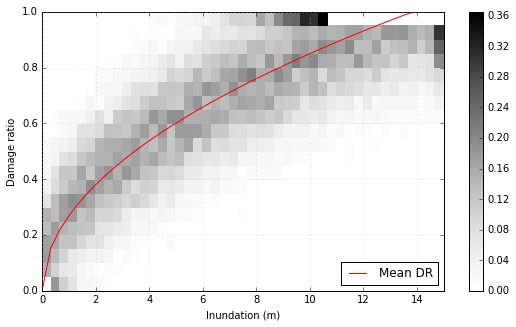

In [8]:
# Import damage functions. 
from toy_model_module import damage_fcns

# Calculate damage function and total damage (in USD) for each property. 
damage = []
for _,row in foc_adpts.iterrows():
    dfcn = damage_fcns(row['gd_inund'],row['CostOfRepl'],row['PropertyTy'])
    dam = dfcn.damage_fcn2()
    damage.append(dam)

# Add this information to dataframe. 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    foc_adpts['damage_fcn_value'] = pd.Series(damage, index=foc_adpts.index)
    foc_adpts['damage_USD'] = foc_adpts['damage_fcn_value']*foc_adpts['CostOfRepl']
    
# Create figure to demonstrate damage function: 
from toy_model_module import show_damfcn2
show_damfcn2(damage_fcns)

In the next cell, I create a plot displaying the damage for all affected properties. Undamaged properties are plotted in black, while damaged properties are plotted according to the amount of damage. A colorbar for the damages (in USD) is included. The total damage across all properties is written on the top right of the plot. 

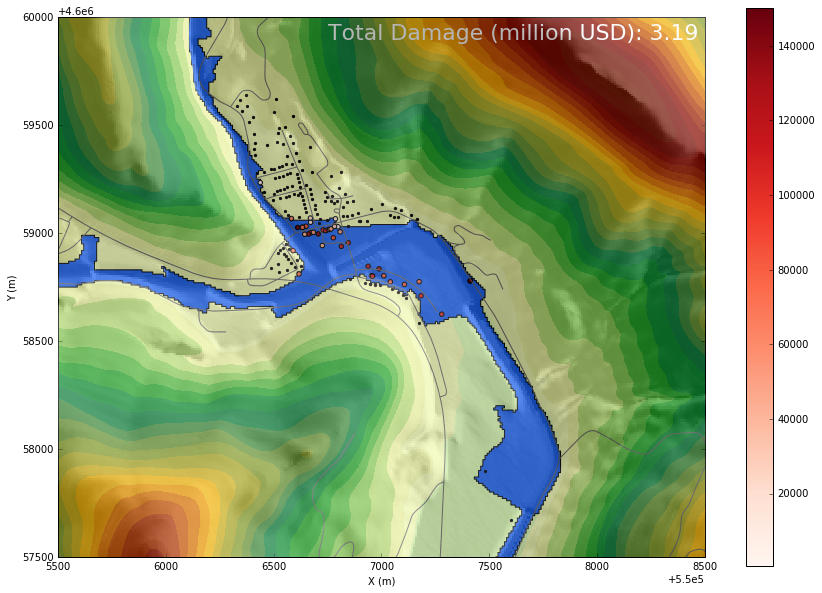

In [9]:
# Print total damage
s = 'Total Damage (million USD): ' + '%.2f' % float(foc_adpts['damage_USD'].sum()/1000000)

# Isolate affected properties
aff_prop = foc_adpts[(foc_adpts['damage_USD']>0)]

# Plot to see where flooding occurred. 
fig = plt.figure(figsize=(14.5, 10))
ax = fig.add_subplot(111)
plot_phoenicia_base(ax,zoom_x,zoom_y,zoom_elev,topocmap,vminmax,creeks,streets,
                    zoom_bounds,only_phoenicia=only_phoenicia)
flood_pgon_gdf.plot(ax=ax,color='#1D64F3')
foc_adpts.plot(ax=ax,color='k',markersize=5)
aff_prop.plot(ax=ax,column='damage_USD',markersize=20,cmap='Reds',legend=True)
plt.text(556750, 4659900, s, fontsize=22, alpha=1,color='white')
plt.show()

## 3. Assessment of risk: <a name="section3"></a>

In Section 2, I described how my toy catastrophe model can be used to estimate damage for a single event. In this section, I use the model to assess flood-related risk for Phoenicia by analyzing data from a 3000-year simulation with the toy cat model. Each year is composed of about 52 weekly "events", which are generated as in Section 2a. Damage from each weekly event is calculated as in Section 2b-2d. The simulation is run using the script, 'multiyear_simulation.py'. 

In [10]:
# Load output
output_file = 'output_2018_12_17_02_57.csv'
output_data = pd.read_csv(os.path.join('./output',output_file),usecols=[1,2,3,4,5])

# Convert dates from strings to datetimes.  
output_data['step_st'] = output_data['step_st'].apply(
    lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
output_data['step_ed'] = output_data['step_ed'].apply(
    lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

# Determine in which each week begins. 
output_data['year'] = output_data['step_st'].apply(lambda x: x.year)

# Now calculate sum of damage for each year. 
years_list = list(range(output_data['year'][0],output_data['year'].iloc[-1]+1))
loss_list = [output_data[(output_data['year']==yr)]['tot_damage'].sum()/1e6 for yr in years_list]

# Place in dataframe. 
yearly_loss = pd.DataFrame({
    'year': years_list,
    'loss': loss_list
})

# Import class for calculating some important risk metrics, initialize with yearly_loss dataframe. 
from toy_model_module import risk_assessment
risk_assess = risk_assessment(yearly_loss)

### a. Distribution of yearly losses

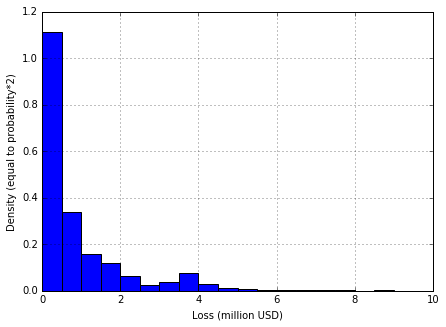

In [11]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
plt.hist(yearly_loss['loss'],bins=np.arange(0,10,0.5),density=True)
#ax = sns.distplot(yearly_loss['loss'],bins=np.arange(0,10,0.5),norm_hist=True,kde=False);
ax.set_xlabel('Loss (million USD)')
ax.set_ylabel('Density (equal to probability*2)')
ax.grid(True)
ax.set_xlim([0,10])
plt.show()

### b. Annual average loss
This is the average loss in a single year. 

In [12]:
print('Annual average loss =',risk_assess.avg_annual_loss(),'million USD')

Annual average loss = 0.865853857408 million USD


### c. Coefficient of variation
Equal to $\frac{std(YearlyLosses)}{mean(YearlyLosses)}$.
Shows how variable the yearly losses are. Lower variation is generally better--means that roughly the same loss can be expected every year. 

In [13]:
print('Standard deviation of losses =',risk_assess.std_annual_loss(),'million USD')
print('Loss coefficient of variation =',risk_assess.cv_annual_loss())

Standard deviation of losses = 1.24518835145 million USD
Loss coefficient of variation = 1.4381045263


### d. Exceedance probability (EP) curve
Plots loss against the probability that the loss will be exceeded in a given timeframe (eg. 1, 2, 5, 10 years). I've written a function that plots an EP curve for a specified timeframe (in years). 

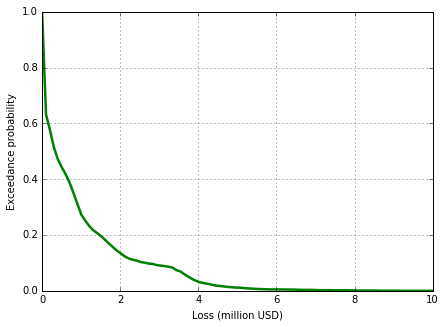

In [14]:
fig,ax = risk_assess.ep_curve(num_yrs=1)

### e. Return periods for various benchmark losses
Return period for a loss that has a probability of being exceeded of 20% in a given year has a return period of 1/0.2 = 5 years. I've written functions to estimate the return period of a specified loss and estimate the loss corresponding to a specified return period. 

In [15]:
spec_loss = 2
return_pd = risk_assess.loss2returnpd(spec_loss)
print('Return period for a',spec_loss,'million dollar loss is',return_pd,'years.')
   
return_period = 50
retn_loss = risk_assess.returnpd2loss(return_period)
print('A return period of',return_period,'years is associated with a loss of',
      np.around(retn_loss,decimals=2),'million USD.')

Return period for a 2 million dollar loss is 7.4 years.
A return period of 50 years is associated with a loss of 4.4 million USD.


## 4. How the model might be improved: <a name="section4"></a>

The model is a toy, and cannot be used to accurately assess risk. Some ways in which the model could be improved given more time and resources are described below. 

Alternative event generation methodologies could eliminate several of the [probably invalid] assumptions in my event generation methodology (described in Section 2a). Alternative methodologies might make use of: 
* **An atmospheric general circulation model with dynamical downscaling, coupled with a hydrological model.** Together, these tools can be used to generate time series of gage heights over a range of climatic states. It would also make the assumption that gage heights are independent from week to week unnecessary. Unfortunately, using these tools is too computationally expensive for my laptop and would introduce a variety of uncertainties and potential biases that don't exist in observational data. For example, this technique might have difficulty simulating extreme precipitation (a well-known issue with GCMs), which leads to the largest and most important flood events. Using an ensemble of GCM/downscaling/hydrological model combinations would be still more computationally expensive, but might eliminate some biases. 
* **A longer timeseries of observations.** Although observations on the Esopus and Stony Clove Creeks are only available after 2007 on the USGS website, I believe that earlier obervations do exist and could be obtained by contacting the USGS. Using a longer observational window would provide a more comprehensive picture of Phoenicia's hydrological climate, and might therefore improve the quality of the generated events. 
* **Generative Adversarial Networks (GANs) to create aritifical gage height time series.** I know that GANs have been successfully used to create artifical time series for medical applications (Esteban et al. 2017, arXiv:1706.02633). Maybe they could also be used to create artificial time series of gage heights for the Esopus and Stony Clove creeks, based on past data? This would allow me to generate long time series of gage heights without the computational cost or potential biases of the GCMs/hydrological models, and without the assumption of independence between weekly gage height observations. I should note that I know very little about GANs, so I have no idea if this is feasible. It's just an idea. 

A more detailed survey of Phoenicia and the surrounding area might also eliminate some issues with my local intensity calculations and exposure data. 
* I could use a 2 meter Digital Elevation Model instead of the 10 meter DEM I used above. I could also go to Phoenicia and manually verify the coordinates and elevations of the streams and properties. This might eliminate some issues I had with the accuracy/compatibility of my datasets (eg. properties experiencing flooding with water levels <1m above normal, streams migrating a few meters above the valley sides). 
* I could also gather more comprehensive information about each property in Phoenicia--use, construction, contents, year of construction, whether it has a basement, etc. I'm not sure where to find this information. I might find some on zillow.com, and some more might be available through publically available databases or through FEMA (maybe?). I don't really know where I'd find the rest. This would make the damage calculations more accurate. 
* I could also incorporate other streams into the analysis. Although the Stony Clove and Esopus creeks are definitely the most significant streams in the area, a small creek runs through Phoenicia and several streams merge with the Esopus and Stony Clove creeks between the stream gages and Phoenicia. Taking these additional streams into account might improve local intensity calculations, but would probably also require use of a hydrological model. 

Use of a hydrological model could improve local intensity calculations. 
* This might improve the calculations by more accurately relating gage heights on the Stony Clove and Esopus creeks to the water levels in Phoenicia, and to the water levels downstream of the two creeks' confluence. 

Better damage functions, which take more detailed property information into account, could improve damage calculations.
* I could use one of the many damage functions in the scientific literature. These damage functions were not useful for the toy model because the exposure data I used was very limited. They would be more useful if I had compiled more detailed exposure data. 